In [1]:
import pickle
import os
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sys
sys.path.append('../') 
from CagePreprocessing import cages, displays, tiles, cells, metadata

In [2]:
chip_id = 159

path_tiles = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/Tiles/'
path_data = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/'
path_bf_tiles = os.path.join(path_tiles, 'BF_illumination_correction')
path_raw_tiles = os.path.join(path_tiles, 'Raw')

# path_predicted_mask = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}"
# path_predicted_mask = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}_3_last'
path_predicted_mask = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}_roi_after_selection'

# pickle file to save the dictionaries at each step of the process
pickle_file_path = os.path.join(os.path.dirname(path_predicted_mask), f'{chip_id}_labels_IS.pkl')
pickle_file_path_filtered = pickle_file_path.split('.')[0] + '_area_filtered.pkl'
pickle_file_path_filtered_global = pickle_file_path.split('.')[0] + '_filtered_global.pkl'
pickle_file_path_filtered_global_ID = pickle_file_path_filtered_global.split('.')[0] + '_cage_ID.pkl'

# path df
path_df_cages = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/{chip_id}_masks/df_{chip_id}_IS_cages.csv'
path_df_cells = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/filtered_output_2.tsv' # combined df filtered to avoid redundant cells
path_df_cells_with_cage = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/df_{chip_id}_cell_cage.csv' # add a cage_id column to associate each cell to a cage ID

path_df_all_cages_final = os.path.join(path_data, f"{chip_id}_20X_T0.cages.all.tsv")
path_df_cages_final = os.path.join(path_data, f"{chip_id}_20X_T0.cages.tsv")
path_df_cells_final = os.path.join(path_data, f"{chip_id}_20X_T0.cells.tsv")
path_df_tiles_final = os.path.join(path_data, f"{chip_id}_20X_T0.tiles.tsv")

txt_file_cages_columns = '/mnt/data3/groups/minos/GitHub_Minos/Resources/Data/cages_load_save_cols.txt'
txt_file_cells_columns = '/mnt/data3/groups/minos/GitHub_Minos/Resources/Data/cells_load_save_cols.txt'

theoretical_central_cage_id = '11_16'
true_central_cage_id = '11_16' # this is the same cage because all the cages are on the stitch

tile_id_0_0 = '8012' # contain the cage 0_0
tile_id_first = '8012'  # first tile; even without any cage
tile_id_last_row = '8035' # last tile of the row - top left corner

# filter on pixel area
min_px_area, max_px_area = 300, 950 # 860
min_complete_cage, max_complete_cage = 700, 950

## values in PIXEL
x_next_cage_same_row = 985 # distance in px 
y_next_cage_same_column = 985 
x_quincunx = x_next_cage_same_row/2
y_quincunx =  y_next_cage_same_column/2

width, height = cages.get_image_dimensions(path_raw_tiles)
size_tile = width
mpp_tile = metadata.extract_mpp_first_tile(path_raw_tiles)
nb_col = 32  # number of cages in a row (<=> number of columns)
nb_row = 23
y_last_cage_row = 933
x_cage_0_0 = 1010
y_cage_0_0 = 980 # local value of the cage 

# global value of cage 0_0 in pixel
x_cage_0_0_global, y_cage_0_0_global = cages.global_cage_coordinates_for_specific_cage(path_tiles = path_raw_tiles, tile_id = tile_id_0_0, x_cage = x_cage_0_0, y_cage = y_cage_0_0, px_output=True, mpp_output=False)
print(f'cage 0_0: ({x_cage_0_0_global}, {y_cage_0_0_global}) px - global coordinates')

cage 0_0: (1010, 980) px - global coordinates


In [3]:
## extract BF channel index from metadata
try:
    tile_name = [tile for tile in os.listdir(path_raw_tiles)][0]
    dict_channel_tile = metadata.extract_channel_name(path_raw_tiles, tile_name, display=False)
    bf_id = next(key for key, value in dict_channel_tile['Channels'].items() if value == 'BF')
except (IndexError) as e:
    # Handle specific exceptions (e.g., file not found, missing 'BF' channel, no items in the list)
    print(f"Error: {e}.\nCannot find the index of the BF channel in the metadata. Get it manually.")
    
    
bf_id = 3

Error: list index out of range.
Cannot find the index of the BF channel in the metadata. Get it manually.


In [4]:
# chip_id = 178

# path_tiles = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/Tiles/'
# path_bf_tiles = os.path.join(path_tiles, 'BF-T0')
# path_raw_tiles = os.path.join(path_tiles, 'Raw')

# path_predicted_mask = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/predicted_mask_{chip_id}"

# # pickle file to save the dictionaries at each step of the process
# pickle_file_path = os.path.join(os.path.dirname(path_predicted_mask), f'{chip_id}_labels_IS.pkl')
# pickle_file_path_filtered = pickle_file_path.split('.')[0] + '_area_filtered.pkl'
# pickle_file_path_filtered_global = pickle_file_path.split('.')[0] + '_filtered_global.pkl'
# pickle_file_path_filtered_global_ID = pickle_file_path_filtered_global.split('.')[0] + '_cage_ID.pkl' # 70 MB for Chip 178 final dictionary

# # path df
# path_df_cages = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/df_178_IS_cages.csv'
# path_df_cages_cell_count = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/df_178_IS_cages_with_cell_counts.csv'
# path_df_cells = '/mnt/data1/users/lminaud/path_chips/Chip178/178_data/20x/26_Sep_2024___14h_25m_37s_178_20X.cells.tsv'
# path_df_cells_with_cage = '/mnt/data1/users/lminaud/path_chips/Chip178/178_data/20x/df_cell_cage.csv' # add a cage_id column to associate each cell to a cage ID

# theoretical_central_cage_id = '21_50' # tile 0734 - visualized on the stitch
# true_central_cage_id = '21_50' 

# tile_id_0_0 = '0043' # contain the cage 0_0
# tile_id_first = '0001'  # first tile; even without any cage
# tile_id_last_row = '0041' # last tile of the row - top left corner

# # filter on pixel area
# min_px_area, max_px_area = 270, 1350
# min_complete_cage, max_complete_cage = 1230, 1350

# ## values in PIXEL
# mpp_tile = 0.325
# size_tile = 2304
# x_next_cage_same_row = 680 # distance in px 
# y_next_cage_same_column = 1470 # distance in px 
# nb_col = 115
# nb_row = 41
# y_last_cage_row = 1656
# x_cage_0_0 = 270
# y_cage_0_0 = 2150 # local value of the cage if the tile 0001 contains the cage 0_0. Otherwise, calculate the cage global value 

# # global value of cage 0_0
# x_cage_0_0_global, y_cage_0_0_global = cages.global_cage_coordinates_for_specific_cage(path_tiles = path_raw_tiles, tile_id = tile_id_0_0, x_cage = x_cage_0_0, y_cage = y_cage_0_0, px_output=True, mpp_output=False)
# print(f'cage 0_0: ({x_cage_0_0_global}, {y_cage_0_0_global}) px - global coordinates')

## Create dictionary with coordinates for each label

In [5]:
dict_labels_coordinates = cages.process_predicted_masks(path_predicted_mask, path_bf_tiles, tile_size=size_tile, base_size=1152, 
                                                        show=False, lim=None)

In [ ]:
# Save the dictionary to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(dict_labels_coordinates, file)

print(f"Dictionary saved to {pickle_file_path}")

## Cages' area
- Filter on pixel area
- Add to the dictionary if the cage is complete in the tile based on its area

In [ ]:
# Load dictionary 
with open(pickle_file_path, 'rb') as file:
    dict_labels_coordinates = pickle.load(file)
print(len(dict_labels_coordinates))

In [6]:
dict_area = cages.add_area_to_dict(dict_labels_coordinates)

In [ ]:
tile_id = '8433'
displays.display_tile_with_borders_and_area(path_bf_tiles=path_bf_tiles, tile_id = tile_id, result_dict=dict_area, 
                                            show_area=True, suffix = '')

## Filter on pixel area

In [ ]:
filtered_result_dict = cages.filter_dictionary_by_area(dict_area, filter_area_range=[min_px_area, max_px_area], complete_cage_range=[min_complete_cage, max_complete_cage])
print(len(filtered_result_dict))

In [ ]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered, 'wb') as file:
    pickle.dump(filtered_result_dict, file)

print(f"Dictionary saved to {pickle_file_path_filtered}")

## Add global center coordinates

In [ ]:
# Load dictionary 
with open(pickle_file_path_filtered, 'rb') as file:
    filtered_result_dict = pickle.load(file)
print(len(filtered_result_dict))

In [11]:
dict_global_coord_cages = cages.dict_global_cage_coordinates(path_raw_tiles=path_raw_tiles, result_dict=filtered_result_dict, suffix='')

In [ ]:
print(dict_global_coord_cages[tile_id_0_0][1].keys())

In [ ]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global, 'wb') as file:
    pickle.dump(dict_global_coord_cages, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global}")

## Identify cages

In [5]:
# Load dictionary 
with open(pickle_file_path_filtered_global, 'rb') as file:
    dict_global_coord_cages = pickle.load(file)
print(len(dict_global_coord_cages))

480


In [6]:
theta_degrees = cages.calculate_theta_angle(
    path_raw_tiles = path_raw_tiles, 
    tile_id_first_cage = tile_id_0_0, # contain the cage 0_0
    tile_id_ref = tile_id_first, # first tile; even without any cage
    tile_id_last = tile_id_last_row, # last tile of the row
    suffix = None,
    dist_btw_cages_px = x_next_cage_same_row, # distance between two center cages in pixels
    nb_col = nb_col, # number of cages in a row (<=> number of columns)
    y_first_cage = y_cage_0_0_global, # y value of cage 0_0 in pixel 
    y_last_cage_row = y_last_cage_row, # y value of the last cage in pixel 
)

Theta (degrees) = 2.1


In [7]:
## line
# dict_theoretical_cage_id = cages.dict_id_cage_theoretical_coord_angle_cages_in_line(nb_row=nb_row, nb_col=nb_col, x_next_cage_same_row=x_next_cage_same_row*mpp_tile, y_next_cage_same_column=y_next_cage_same_column*mpp_tile, theta=theta_degrees, x_cage_0_0=x_cage_0_0*mpp_tile, y_cage_0_0=y_cage_0_0_global*mpp_tile, mpp_20x=mpp_tile)

## quincunx 
dict_theoretical_cage_id = cages.dict_id_cage_theoretical_coord_angle(nb_cage_row=nb_row, nb_cage_col=nb_col, x_next_cage_same_row=x_next_cage_same_row*mpp_tile, y_next_cage_same_column=y_next_cage_same_column*mpp_tile, theta=theta_degrees, x_cage_0_0=x_cage_0_0*mpp_tile, y_cage_0_0=y_cage_0_0_global*mpp_tile, x_quincunx=x_quincunx*mpp_tile, y_quincunx=y_quincunx*mpp_tile, mpp=mpp_tile)

In [8]:
tile_id = '8071'
print(dict_global_coord_cages[tile_id][2]['center_global']) 

(14722, 3468)


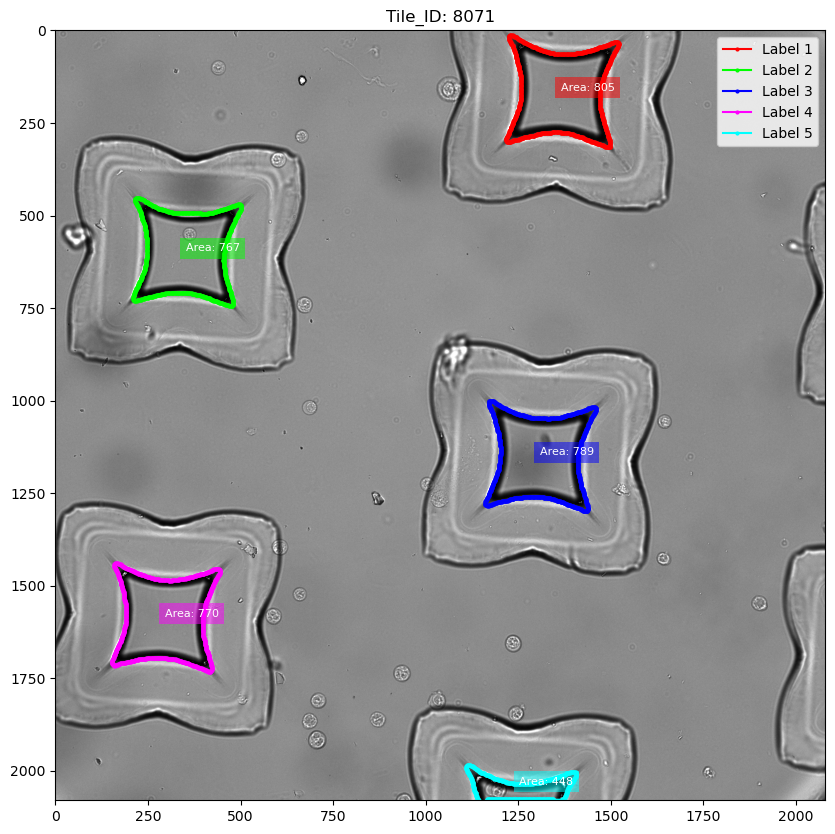

In [9]:
displays.display_tile_with_borders_and_area(path_bf_tiles=path_bf_tiles, tile_id = tile_id, result_dict=dict_global_coord_cages, 
                                            show_area=True, suffix = '')

In [10]:
dict_id = cages.associate_cage_id_to_coord_dict(dict_global_coord_cages, dict_theoretical_cage_id) # match

In [11]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global_ID, 'wb') as file:
    pickle.dump(dict_id, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global_ID}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_filtered_global_cage_ID.pkl


## Display cage ID

In [12]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)
print(len(dict_id))

480


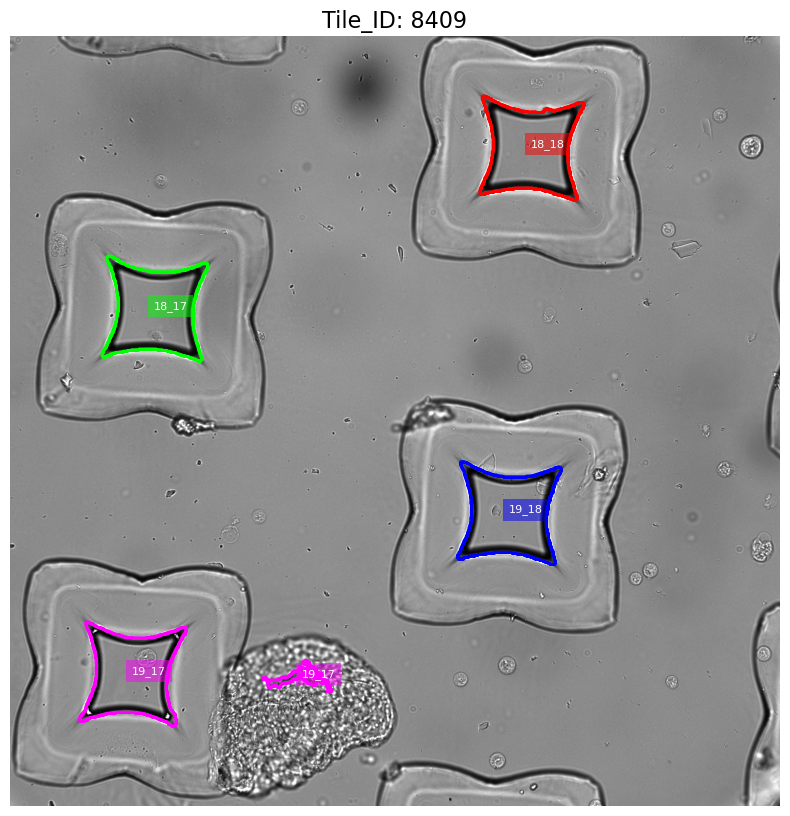

In [13]:
displays.display_cages_with_consistent_colors(path_bf_tiles=path_bf_tiles, tile_id='8409', result_dict=dict_id, display_ids=True, suffix = '')

## Change cage ID based on the central cage

In [14]:
# not sure ths is working as I could not verify with Chip 159
updated_dict = cages.reassign_cageID_from_dict(dict_id, theoretical_central_cage_id, true_central_cage_id)

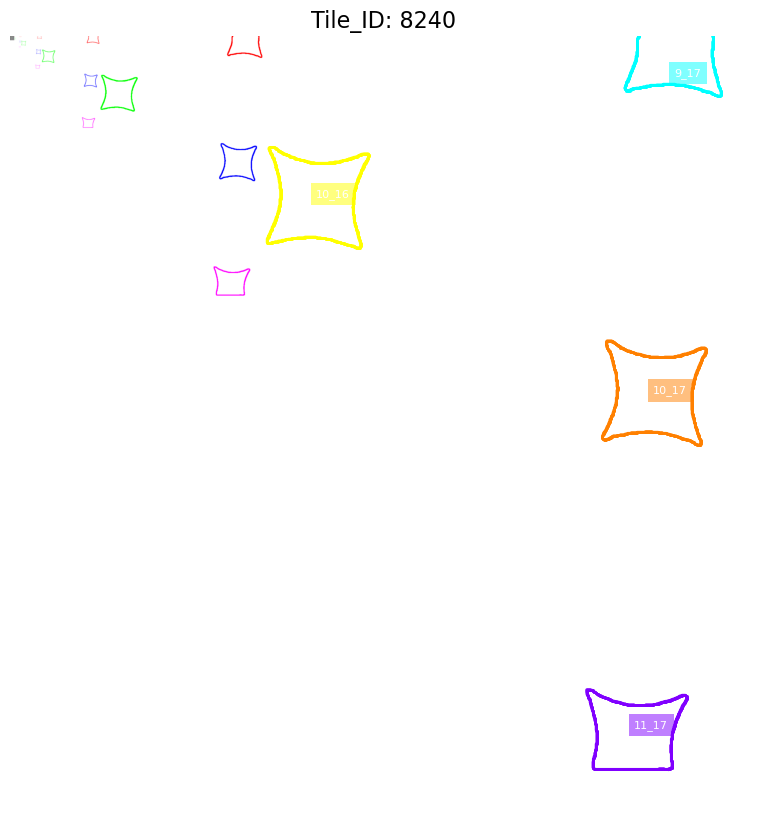

In [15]:
displays.display_cages_with_consistent_colors(path_bf_tiles=path_bf_tiles, tile_id='8240', result_dict=updated_dict, display_ids=True, suffix = '')

## Add cell count for each cage to the dictionary

In [16]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)
print(len(dict_id))

480


In [17]:
# # Swap the two columns of X and Y of the df_cells - do it 1 time !

# df_cells = pd.read_csv(path_df_cells, sep='\t', dtype={'TileID': str})

# # Step 1: Rename 'CellCenterX' to a temporary column 'TempCol' to avoid losing its data
# df_cells = df_cells.rename(columns={'CellCenterX': 'TempCol'})

# # Step 2: Rename 'CellCenterY' to 'CellCenterX'
# df_cells = df_cells.rename(columns={'CellCenterY': 'CellCenterX'})

# # Step 3: Rename 'TempCol' (which holds the original 'CellCenterX') to 'CellCenterY'
# df_cells = df_cells.rename(columns={'TempCol': 'CellCenterY'})

# df_cells.to_csv(path_df_cells, sep='\t', index=False)

### Remove redundant cages in a tile

In [18]:
dict_id = cages.resolve_duplicates_in_tile(dict_id)

Duplicate found: cage_id=2_28, tile_id=8081
Duplicate found: cage_id=14_23, tile_id=8317
Duplicate found: cage_id=17_11, tile_id=8356
Duplicate found: cage_id=17_11, tile_id=8356
Duplicate found: cage_id=19_10, tile_id=8404
Duplicate found: cage_id=19_17, tile_id=8408
Duplicate found: cage_id=19_17, tile_id=8409
Duplicate found: cage_id=19_17, tile_id=8433


In [19]:
dict_id = cages.count_cells_in_cages(dict_id, path_df_cells)

In [20]:
tile_id = '8433'
label = 4
print(dict_id[tile_id][label]['cage_id'])
print(dict_id[tile_id][label]['Cell_Count_Cage'])
print(dict_id[tile_id][label]['complete'])
print(dict_id[tile_id][label]['area'])

20_18
0
True
741


In [21]:
# Display single cell cages

# Iterate through each TileID in the dictionary
for tile_id, tile_data in dict_id.items():
    # Iterate through each cage (label) in the tile
    for label, cage_data in tile_data.items():
        # Check if 'Cell_Count_Cage' exists and equals 1
        if cage_data.get('Cell_Count_Cage') == 1:
            if cage_data.get('complete') == True:
                # Assuming 'cage_id' is part of the cage_data
                cage_id = cage_data.get('cage_id', 'Unknown Cage ID')  # Default value if 'cage_id' is missing
                print(f"TileID: {tile_id}, Cage ID: {cage_id}")

TileID: 8014, Cage ID: 0_2
TileID: 8014, Cage ID: 1_2
TileID: 8015, Cage ID: 1_4
TileID: 8017, Cage ID: 0_7
TileID: 8021, Cage ID: 0_12
TileID: 8023, Cage ID: 0_15
TileID: 8023, Cage ID: 1_14
TileID: 8025, Cage ID: 0_18
TileID: 8026, Cage ID: 0_18
TileID: 8026, Cage ID: 0_19
TileID: 8029, Cage ID: 1_22
TileID: 8031, Cage ID: 0_26
TileID: 8032, Cage ID: 0_26
TileID: 8034, Cage ID: 0_30
TileID: 8035, Cage ID: 0_30
TileID: 8035, Cage ID: 0_31
TileID: 8037, Cage ID: 1_2
TileID: 8038, Cage ID: 1_2
TileID: 8040, Cage ID: 1_5
TileID: 8040, Cage ID: 2_6
TileID: 8041, Cage ID: 0_7
TileID: 8041, Cage ID: 1_6
TileID: 8041, Cage ID: 2_6
TileID: 8043, Cage ID: 2_10
TileID: 8044, Cage ID: 1_11
TileID: 8044, Cage ID: 2_10
TileID: 8046, Cage ID: 1_14
TileID: 8046, Cage ID: 1_13
TileID: 8046, Cage ID: 2_14
TileID: 8047, Cage ID: 0_15
TileID: 8047, Cage ID: 1_14
TileID: 8047, Cage ID: 2_14
TileID: 8048, Cage ID: 1_16
TileID: 8050, Cage ID: 0_19
TileID: 8050, Cage ID: 1_19
TileID: 8052, Cage ID: 1_22
Til

In [22]:
# Cage ID you want to search for
search_cage_id = '19_17'

# List to store TileIDs associated with the given cage_id
matching_tile_ids = []

# Iterate through each TileID in the dictionary
for tile_id, tile_data in dict_id.items():
    # Iterate through each cage (label) in the tile
    for label, cage_data in tile_data.items():
        # Check if 'Cell_Count_Cage' is 1 and 'complete' is True
        if cage_data.get('complete') == True:
            # Check if the cage_id matches the search_cage_id
            if cage_data.get('cage_id') == search_cage_id:
                matching_tile_ids.append(tile_id)

# Print or use the list of TileIDs associated with the given cage_id
print(f"TileIDs associated with cage_id '{search_cage_id}': {matching_tile_ids}")

TileIDs associated with cage_id '19_17': ['8408', '8409', '8432', '8433']


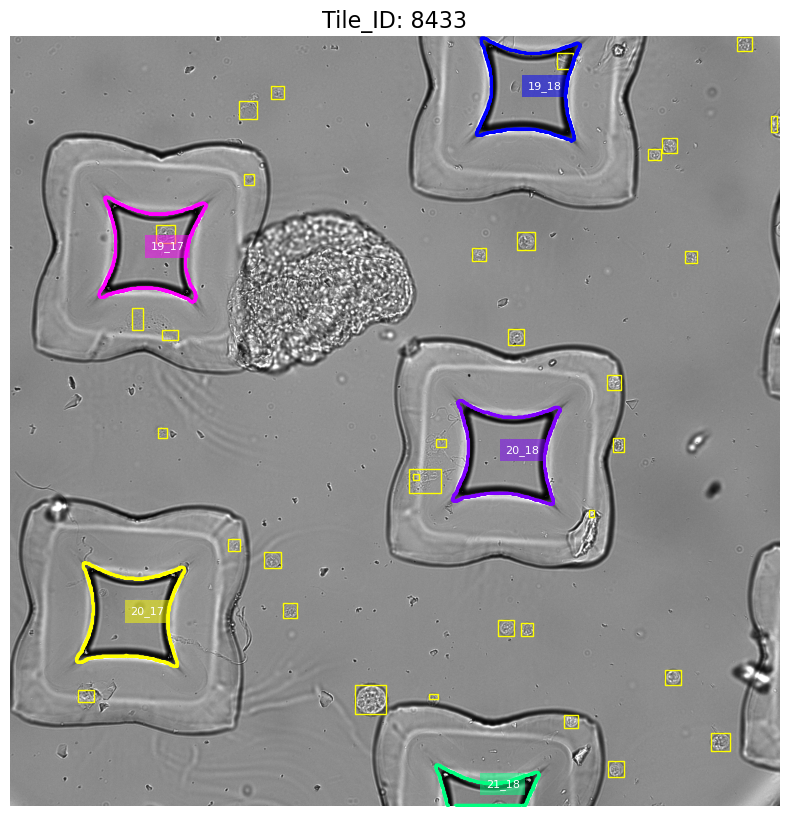

In [28]:
displays.display_cages_with_consistent_colors_with_cells(path_bf_tiles=path_bf_tiles, tile_id='8433', result_dict=dict_id, path_df_cells = path_df_cells, display_ids=True, suffix = '')

In [24]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global_ID, 'wb') as file:
    pickle.dump(dict_id, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global_ID}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_filtered_global_cage_ID.pkl


## Associate each cell to a cage ID or Nan value to df_cells

In [25]:
# this does not modify the dictionary - only the df_cells 

In [26]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)

In [27]:
df_cells_cageID_col = cells.assign_cells_to_cages(dict_id, path_df_cells)

In [28]:
# save df
df_cells_cageID_col.to_csv(path_df_cells_with_cage, index=False)

In [ ]:
df_cells_cageID_col[df_cells_cageID_col['CageID'] == '19_17']

## Create a df from the dictionary 

In [31]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)

In [ ]:
tile_id = '8012'
label = 1

dict_id[tile_id][label].keys()

In [ ]:
df_geo = cages.create_geodf_from_dict(dict_id)
df_geo


In [ ]:
df_geo[df_geo['cage_id'] == '19_17']

## Additional columns to df
### location tile, Ref Tile

In [ ]:
df_loc_tiles = tiles.add_location_tile_df(df_geo, path_raw_tiles, suffix='') # tile_row_col
df_loc_tiles

In [ ]:
df_cages_new_col = cells.add_ref_tile_col(df_loc_tiles) # Ref_TileID
df_cages_new_col

In [ ]:
# Split 'center_local' into two columns: X_Cage_Center_Local and Y_Cage_Center_Local
df_cages_new_col[['X_Cage_Center_Local', 'Y_Cage_Center_Local']] = pd.DataFrame(df_cages_new_col['center_local'].tolist(), index=df_cages_new_col.index)

# Split 'center_global' into two columns: X_Cage_Center_Global and Y_Cage_Center_Global
df_cages_new_col[['X_Cage_Center_Global', 'Y_Cage_Center_Global']] = pd.DataFrame(df_cages_new_col['center_global'].tolist(), index=df_cages_new_col.index)

# Optionally, drop the original 'center_local' and 'center_global' columns if they are no longer needed
df_cages_new_col = df_cages_new_col.drop(columns=['center_local', 'center_global'])

df_cages_new_col


In [38]:
# save df
df_cages_new_col.to_csv(path_df_cages, index=False)

## Add missing columns and rename columns

### Cage df

In [29]:
df_cages_new_col = pd.read_csv(path_df_cages)
df_cages_new_col = cells.change_column_names(df_cages_new_col)
df_cages_new_col = cells.add_col_from_txt_file(df_cages_new_col, path_txt_file=txt_file_cages_columns)
df_cages_new_col

,Tile_ID,area,Cage_Status,Cage_ID,geometry_cages,Cell_Count_Cage,Tile_Row_Col,Ref_TileID,X_Cage_Center_Local,Y_Cage_Center_Local,...,H_UMIs_cage,M_UMIs_cage,UGC_cage,MT_cage,RP_cage,UMAP1_sc,UMAP2_sc,PCA1_sc,PCA2_sc,Leiden_sc
0,8012,818,complete,0_0,"LINESTRING (1116 1141, 1116 1139, 1116 1137, 1...",0,"(0, 0)",8012,1009,967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8012,619,NaN,0_1,"LINESTRING (1652 2078, 1653 2077, 1655 2077, 1...",0,"(0, 0)",8013,1927,1520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8012,701,complete,1_0,"LINESTRING (2078 966, 2077 965, 2077 964, 2077...",0,"(0, 0)",8036,950,1935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8013,822,complete,0_2,"LINESTRING (1160 1803, 1160 1801, 1160 1800, 1...",0,"(0, 1)",8014,1669,1007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8013,794,complete,0_1,"LINESTRING (1589 785, 1589 783, 1589 781, 1589...",2,"(0, 1)",8013,656,1442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,8490,806,complete,22_30,"LINESTRING (937 1442, 937 1440, 937 1439, 937 ...",2,"(19, 22)",8466,1313,790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2314,8490,754,complete,22_29,"LINESTRING (1371 424, 1371 422, 1370 421, 1369...",2,"(19, 22)",8489,302,1226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2315,8491,816,complete,21_31,"LINESTRING (430 1159, 430 1157, 429 1156, 428 ...",0,"(19, 23)",8491,1029,279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2316,8491,479,NaN,22_30,"LINESTRING (802 0, 801 0, 799 0, 798 0, 796 0,...",0,"(19, 23)",8466,78,722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Remove redundant cages in the same tile (wrong prediction of cages that have not been filtered on the area)
df_cages_new_col = cages.resolve_duplicates(df_cages_new_col)

Removed rows (Tile_ID, Cage_ID):
Tile_ID: 8356, Cage_ID: 17_11
Tile_ID: 8356, Cage_ID: 17_11
Tile_ID: 8404, Cage_ID: 19_10
3 cages have been removed.


In [41]:
columns_to_drop = ['area']
df_cages_new_col = df_cages_new_col.drop(columns=[col for col in columns_to_drop if col in df_cages_new_col.columns])

In [ ]:
df_cages_new_col[df_cages_new_col['Cage_ID'] == '19_17']

In [43]:
df_cages_new_col.to_csv(path_df_all_cages_final, sep='\t', index=False)

In [44]:
## filter df to get one unique cage presents on the reference tile ID
df_cages_new_col_ref = df_cages_new_col[df_cages_new_col['Tile_ID'] == df_cages_new_col['Ref_TileID']]
df_cages_new_col_ref.to_csv(path_df_cages_final, sep='\t', index=False)

### Cell df

In [ ]:
df_cells_cageID = pd.read_csv(path_df_cells_with_cage)
df_cells_cageID

In [ ]:
df_cells_cageID = cells.change_column_names(df_cells_cageID)
df_cells_cageID = cells.add_col_from_txt_file(df_cells_cageID, path_txt_file=txt_file_cells_columns)
df_cells_cageID

In [ ]:
df_cells_cageID.columns

In [48]:
df_cells_cageID.to_csv(path_df_cells_final, sep='\t', index=False)

### Tile df

In [ ]:
df_tiles = cells.create_df_tiles(df_cages_new_col, df_cells_cageID, path_raw_tiles, size_tile)
df_tiles = cells.add_col_bf_intensity_median(df_tiles, path_raw_tiles, bf_id, suffix='')

df_tiles = cells.change_column_names(df_tiles)
df_tiles.to_csv(path_df_tiles_final, sep='\t', index=False)

In [ ]:
df_tiles

## Add Ref_TileID column to cells df

In [ ]:
df_cells_cageID = pd.read_csv(path_df_cells_final, sep='\t')

In [ ]:
df_cages_new_col = pd.read_csv(path_df_all_cages_final, sep='\t')

In [ ]:
import pandas as pd
import numpy as np

# Initialize a list to store the new 'Ref_TileID' values
ref_tileid_list = []

# Loop through each row in df_cells_cageID
for i, row in df_cells_cageID.iterrows():
    cage_id = row['Cage_ID']
    
    if pd.isna(cage_id):
        # If Cage_ID is NaN, append NaN to the list
        ref_tileid_list.append(np.nan)
    else:
        # Find the corresponding Ref_TileID in df_cages_new_col
        ref_tileid = df_cages_new_col.loc[df_cages_new_col['Cage_ID'] == cage_id, 'Ref_TileID']
        
        # If a match is found, append it to the list, otherwise append NaN
        if not ref_tileid.empty:
            ref_tileid_list.append(ref_tileid.iloc[0])  # Get the first match (should be unique)
        else:
            ref_tileid_list.append(np.nan)

# Add the new Ref_TileID column to df_cells_cageID
df_cells_cageID['Ref_TileID'] = ref_tileid_list

# Display the updated DataFrame
df_cells_cageID


In [61]:
df_cells_cageID.to_csv(path_df_cells_final, sep='\t', index=False)

## single cell counts

In [ ]:
# Step 1: Filter where Tile_ID == Ref_TileID
df_filtered = df_cells_cageID[df_cells_cageID['Tile_ID'] == df_cells_cageID['Ref_TileID']]

# Step 2: Group by Cage_ID and count the number of rows for each Cage
cage_counts = df_filtered.groupby('Cage_ID').size()

# Step 3: Filter cages with only one cell
single_cell_cages = cage_counts[cage_counts == 1]

cage_id_list = single_cell_cages.index.tolist()

len(cage_id_list)

In [ ]:
df_cells_cageID[df_cells_cageID['Cage_ID'] == '19_17']

In [ ]:
len(list(set(cage_id_list)))